# Loading dependencies

In [ ]:
import datetime as dt
import logging
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb #Xgboost version 3.0

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s',
                    level=logging.WARNING)

logging.getLogger('matplotlib').setLevel(logging.WARNING)

from data_preprocessor import preprocessDataset
from train import modelData, modelDataWithGridSearch

# Importing the Data

Data was downloaded from https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data as csv file

In [ ]:
csv_path = '311ServiceRequests.csv'

data = pd.read_csv(csv_path,usecols=['Created Date', 'Closed Date','Agency','Borough','Complaint Type','City','Street Name',
                 'Open Data Channel Type','Latitude','Longitude'])

In [27]:
data.tail()

,Created Date,Closed Date,Agency,Complaint Type,Street Name,City,Borough,Open Data Channel Type,Latitude,Longitude
39380344,10/21/2024 12:57:04 PM,10/21/2024 12:57:04 PM,DOHMH,Rodent,59 STREET,WOODSIDE,QUEENS,PHONE,40.745128,-73.905674
39380345,10/21/2024 11:26:14 AM,10/21/2024 11:26:14 AM,DOHMH,Rodent,EMMONS AVENUE,BROOKLYN,BROOKLYN,MOBILE,40.583919,-73.937886
39380346,10/21/2024 09:27:01 PM,10/21/2024 10:06:24 PM,NYPD,Abandoned Vehicle,7 AVENUE,NaN,MANHATTAN,ONLINE,40.748469,-73.992461
39380347,10/21/2024 01:50:11 PM,10/21/2024 02:34:30 PM,NYPD,Abandoned Vehicle,HARRISON AVENUE,BROOKLYN,BROOKLYN,MOBILE,40.706199,-73.953880
39380348,10/22/2024 01:21:33 AM,10/22/2024 02:00:02 AM,NYPD,Drug Activity,PARK AVENUE,FRESH MEADOWS,QUEENS,ONLINE,40.729932,-73.809053


# Preprocessing the data:
includes:
- Taking a sample of the data from 2022 to 2025
- Cleaning data from outliers
- Feature engineering:  
    o Extract sin/cos transformations for latitude and longitude  
    o Derive time-of-day and day-of-week features
    o Drop rows with missing values
- Calculate response time and apply log transformation to achieve normality of the skewed data and reduce the outlier impact and help gradient-based models to learn better

In [ ]:
df = preprocessDataset(data)
# length of data is 7175855

C:\Users\sim-graziella\Documents\Uptimal\data_preprocessor.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanDf['logResponseTime'] = np.log1p(cleanDf['response_time'])


# Train data wth Grid search

In [ ]:
X_train, X_test, y_train, y_test, y_pred, bestModel = modelDataWithGridSearch(df, test_size=0.2, random_state=42, stratify=df['Open Data Channel Type'])

# Train with xgboost

C:\Users\sim-graziella\AppData\Local\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [18:02:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1.24614	validation_0-rmse:1.24685
[1]	train-rmse:1.00579	validation_0-rmse:1.00646
[2]	train-rmse:0.85510	validation_0-rmse:0.85588
[3]	train-rmse:0.75581	validation_0-rmse:0.75660
[4]	train-rmse:0.68029	validation_0-rmse:0.68130
[5]	train-rmse:0.64367	validation_0-rmse:0.64484
[6]	train-rmse:0.60602	validation_0-rmse:0.60736
[7]	train-rmse:0.57449	validation_0-rmse:0.57594
[8]	train-rmse:0.54928	validation_0-rmse:0.55097
[9]	train-rmse:0.53379	validation_0-rmse:0.53545
[10]	train-rmse:0.51453	validation_0-rmse:0.51624
[11]	train-rmse:0.50358	validation_0-rmse:0.50538
[12]	train-rmse:0.49168	validation_0-rmse:0.49353
[13]	train-rmse:0.48655	validation_0-rmse:0.48843
[14]	train-rmse:0.47989	validation_0-rmse:0.48176
[15]	train-rmse:0.47559	validation_0-rmse:0.47748
[16]	train-rmse:0.47293	validation_0-rmse:0.47489
[17]	train-rmse:0.46035	validation_0-rmse:0.46229
[18]	train-rmse:0.45514	validation_0-rmse:0.45728
[19]	train-rmse:0.45174	validation_0-rmse:0.45395
[20]	train

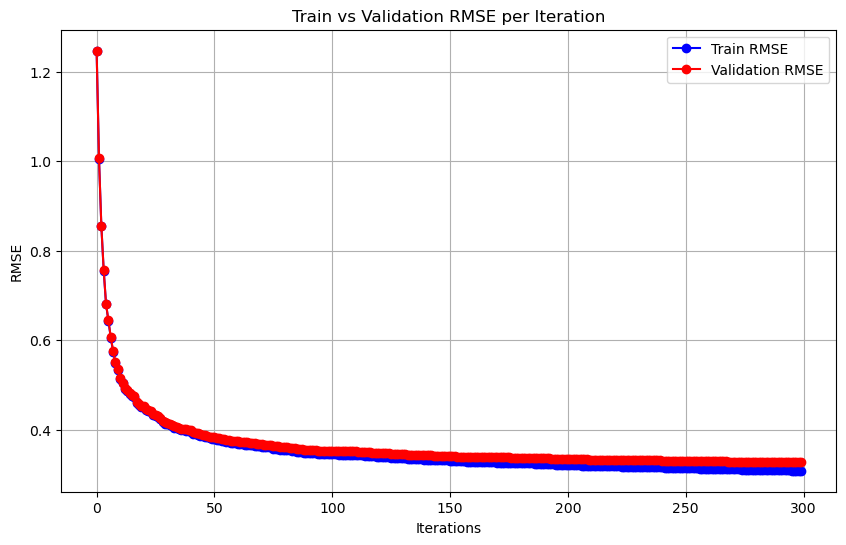

Validation Metrics:
MSE: 0.11
RMSE: 0.33
MAE: 0.17
R-squared: 0.96
R^2 adjusted      : 0.9593
CV-RMSE adjusted  : 16.96


In [ ]:
X_train, X_test, y_train, y_test, y_pred, bestModel = modelData(df, test_size=0.2, random_state=42, stratify=df['Open Data Channel Type'])

# Interpreting the results

- RMSE plateaued: both training and validation RMSE have converged and stabilized, suggesting no overfitting or underfitting  
- MSE = 0.11	Average squared error is low (for log-scale).  
- RMSE = 0.33	Small average deviation in log units (e.g. log-hours).  
    np.exp(0.33) = 1.39 => The predicted response times are typically within a factor of ~1.39 of the true value  
- MAE	= 0.17	Median absolute error is smaller than RMSE (good sign, few big outliers).  
- R² = 0.96	Model explains 96% of the variance in log response time.  
=> No signs of overfitting, model generalizes well to unseen data. 

In [ ]:
# # Get feature importances
# feature_importances = bestModel.feature_importances_

# # Create a DataFrame to store feature importances
# feature_importance_df = pd.DataFrame({'Feature': df[features].columns, 'Importance': feature_importances})

# # Sort the DataFrame by importance
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# print(feature_importance_df)

In [ ]:
# def evaluateAndCompare(y_test_log, y_pred_log):
#     # 1. Metrics in log-space
#     mse_log = mean_squared_error(y_test_log, y_pred_log)
#     rmse_log = np.sqrt(mse_log)
#     mae_log = mean_absolute_error(y_test_log, y_pred_log)
#     r2_log = r2_score(y_test_log, y_pred_log)

#     print("📉 Log-space Metrics:")
#     print(f"  MSE: {mse_log:.4f}")
#     print(f"  RMSE: {rmse_log:.4f}")
#     print(f"  MAE: {mae_log:.4f}")
#     print(f"  R²: {r2_log:.4f}")

#     # 2. Back-transform to real-time
#     y_test_real = np.exp(y_test_log)
#     y_pred_real = np.exp(y_pred_log)

#     # 3. Metrics in real-time units
#     mse_real = mean_squared_error(y_test_real, y_pred_real)
#     rmse_real = np.sqrt(mse_real)
#     mae_real = mean_absolute_error(y_test_real, y_pred_real)
#     r2_real = r2_score(y_test_real, y_pred_real)

#     print("\n⏱️ Real-time Metrics:")
#     print(f"  MSE: {mse_real:.2f}")
#     print(f"  RMSE: {rmse_real:.2f} hours")
#     print(f"  MAE: {mae_real:.2f} hours")
#     print(f"  R²: {r2_real:.4f}")

#     # 4. Return a DataFrame with formatted durations
#     def format_duration(hours):
#         days = int(hours // 24)
#         hrs = int(hours % 24)
#         mins = int((hours * 60) % 60)
#         return f"{days}d {hrs}h {mins}m"

#     result_df = pd.DataFrame({
#         'True (hrs)': y_test_real,
#         'Predicted (hrs)': y_pred_real,
#         'Formatted True': y_test_real.apply(format_duration),
#         'Formatted Pred': y_pred_real.apply(format_duration),
#     })

#     return result_df
